In [20]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import QuantileTransformer


# READ DF + NORMALIZE

In [21]:
df = pd.read_csv("diabetes.csv")
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [23]:
df = df.loc[:, ~df.columns.isin(['Outcome'])]

In [24]:
quantile_trans = QuantileTransformer(n_quantiles=df.shape[0], output_distribution='normal')
df_scaled = pd.DataFrame(quantile_trans.fit_transform(df), columns=df.columns)
df_scaled

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.667327,0.879002,0.042498,0.848159,-5.199338,0.230799,0.677570,1.225627
1,-0.729902,-1.294285,-0.422375,0.371103,-5.199338,-0.747073,-0.060497,0.147598
2,1.097346,1.716615,-0.585788,-5.199338,-5.199338,-1.329045,0.779878,0.215722
3,-0.729902,-1.121536,-0.422375,0.014707,0.420590,-0.528530,-1.246676,-5.199338
4,-5.199338,0.587729,-1.636692,0.848159,0.971779,1.453722,2.793437,0.269580
...,...,...,...,...,...,...,...,...
763,1.560490,-0.570338,0.385144,2.023469,1.053642,0.132747,-1.222172,1.986876
764,-0.286564,0.155863,-0.122862,0.232478,-5.199338,0.708737,-0.109701,-0.222417
765,0.462019,0.124509,0.042498,0.014707,0.558840,-0.795477,-0.659183,0.073599
766,-0.729902,0.305344,-0.910704,-5.199338,-5.199338,-0.252672,-0.065408,1.112388


# K-MEANS-LTS

In [25]:
# Return K_MEANS dengan cluster_id dan distance to centroid
def cluster_maker(dataframe, n_cluster_lts):
    kmeans = KMeans(n_clusters=n_cluster_lts, init='k-means++', random_state=42).fit(dataframe)

    dataframe['distance_to_centroid'] = np.min(kmeans.transform(dataframe), axis=1)
    dataframe['cluster_id'] = kmeans.labels_

    return dataframe

In [26]:
# Memisahkan dataframe & mengurutkan berdasarkan distance
def separate_dataframe(dataframe, n_cluster_lts, sort_column='distance_to_centroid'):
    cluster_dfs = {}

    for i in range(n_cluster_lts):
        cluster_dfs[i] = [dataframe[dataframe['cluster_id'] == i]]
        cluster_dfs[i][0] = cluster_dfs[i][0].sort_values(sort_column, ascending=False)
        
    return cluster_dfs

In [27]:
def KMeans_LTS(df, n_cluster_lts, n_percent):
    clustered_df = cluster_maker(df, n_cluster_lts)
    cluster_dict = separate_dataframe(clustered_df, n_cluster_lts)
    inliers_dfs = []
    outliers_dfs = []

    for cluster_id, df_list in cluster_dict.items():
        # Mengurutkan DataFrame berdasarkan distance_to_centroid secara descending
        sorted_df = df_list[0].sort_values(by='distance_to_centroid', ascending=False)

        # Menghitung jumlah baris yang akan di-trim
        n_rows_to_trim = int(n_percent / 100 * len(sorted_df))

        # Memisahkan inliers dan outliers
        inliers_df = sorted_df.iloc[n_rows_to_trim:]
        outliers_df = sorted_df.iloc[:n_rows_to_trim]

        # Menambahkan cluster_id-out ke outliers
        outliers_df.loc[:, outliers_df.columns.isin(['cluster_id'])] = str(cluster_id) + '-out'

        # Menyimpan DataFrame inliers dan outliers
        inliers_dfs.append(inliers_df)
        outliers_dfs.append(outliers_df)

    # Menggabungkan DataFrame inliers dari semua cluster sesuai dengan index awal
    inliers_result = pd.concat(inliers_dfs).drop(columns=['distance_to_centroid']).sort_index()

    # Menggabungkan DataFrame outliers dari semua cluster
    outliers_result = pd.concat(outliers_dfs).drop(columns=['distance_to_centroid']).sort_index()

    # Return hasil clustering inliers+outliers sesuai dengan index awal
    optimal_cluster = pd.concat([inliers_result, outliers_result], axis=0).sort_index()

    return inliers_result, optimal_cluster

# TEST K-MEANS LTS ALGORITHM with K = 3 and n_percentage = 10

c:\Users\jptri\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\jptri\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\axisgrid.py:1513: UserWarning: The palette list has more values (7) than needed (6), which may not be intended.
  func(x=vector, **plot_kwargs)
c:\Users\jptri\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\axisgrid.py:1513: UserWarning: The palette list has more values (7) than needed (6), which may not be intended.
  func(x=vector, **plot_kwargs)
c:\Users\jptri\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\axisgrid.py:1615: UserWarning: The palette list has more values (7) than needed (6), which may not be intended.
  func(x=x, y=y, **kwargs)
c:\Users\jptri\AppData\Local\

<Figure size 800x800 with 0 Axes>

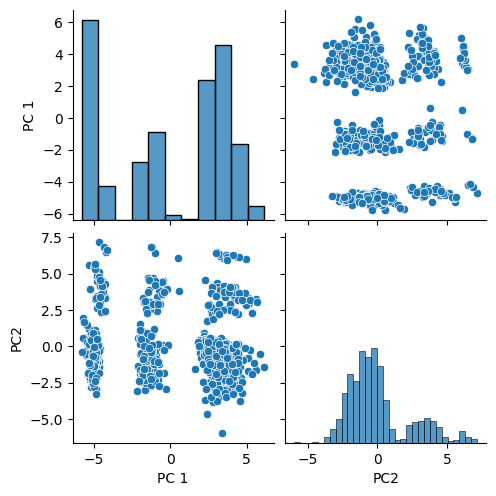

<Figure size 800x800 with 0 Axes>

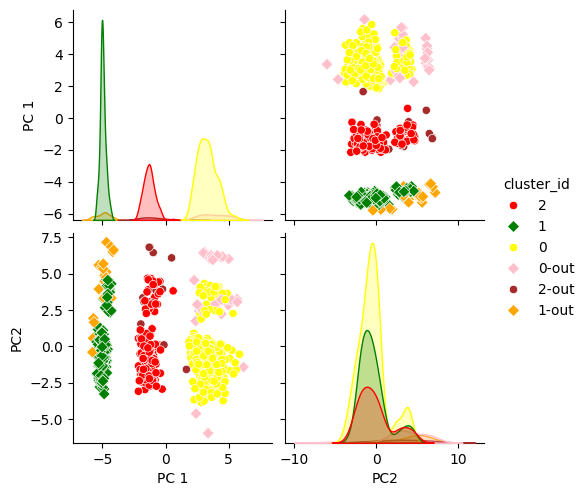

<Figure size 800x800 with 0 Axes>

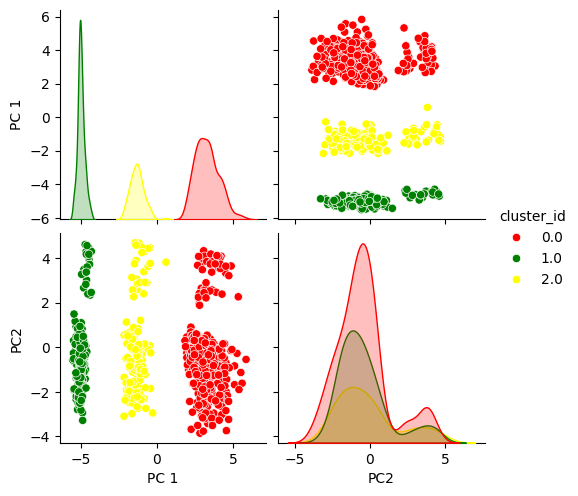

In [28]:
# TEST VISUALIZATION
from sklearn.decomposition import PCA
import seaborn as sns 

# PCA variable input
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)
df_pca = pd.DataFrame(df_pca, columns=['PC 1', 'PC2'])
plt.figure(figsize=(8,8))
sns.pairplot(data=df_pca)

# GET inliers (LTS_result_filtered) and optimal cluster (LTS_result)
test_df = df_scaled.copy()
LTS_result_filtered, LTS_result = KMeans_LTS(test_df, 3, 10)

# PAIR PLOT with OUTLIERS
df_pca['cluster_id'] = LTS_result.loc[:, LTS_result.columns.isin(['cluster_id'])]

plt.figure(figsize=(8,8))
sns.pairplot(data=df_pca, hue='cluster_id', markers=["o", "D"], palette=['red', 'green', 'yellow', 'pink', 'brown', 'orange', 'blue'])

#PAIR PLOT without OUTLIERS
df_pca['cluster_id'] = LTS_result_filtered.loc[:, LTS_result_filtered.columns.isin(['cluster_id'])]

plt.figure(figsize=(8,8))
sns.pairplot(data=df_pca, hue='cluster_id', palette=['red', 'green', 'yellow', 'pink', 'brown', 'orange', 'blue'])

In [29]:
# FIND SILHOUETTE SCORE
from sklearn.metrics import silhouette_score

inliers_no_id = LTS_result_filtered.drop(['cluster_id'], axis=1)
score = silhouette_score(inliers_no_id, LTS_result_filtered['cluster_id'])
print(score)

0.45165164254440654


In [30]:
# Davies Bouldin Score

from sklearn.metrics import davies_bouldin_score

inliers_no_id = LTS_result_filtered.drop(['cluster_id'], axis=1)
score = davies_bouldin_score(inliers_no_id, LTS_result_filtered['cluster_id'])
print(score)

0.9912094421996752


In [31]:
# FIND SILHOUETTE SCORE untuk HASIL CLUSTER dari INLIERS saja
inliers_cluster = KMeans(n_clusters=7, init='k-means++', random_state=42).fit(inliers_no_id)
score = silhouette_score(inliers_no_id, inliers_cluster.labels_)
print(score)

0.3166803908119816


c:\Users\jptri\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [32]:
# Davies Bouldin Score INLIERS SAJA

inliers_cluster = KMeans(n_clusters=7, init='k-means++', random_state=42).fit(inliers_no_id)
score = davies_bouldin_score(inliers_no_id, inliers_cluster.labels_)
print(score)

1.2638084272525938


c:\Users\jptri\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


# K and PERCENTAGE OPTIMIZATIONS

In [33]:
def best_percentage(dataframe, n_cluster_lts):
    best_silhouette_score = 0
    best_percent = 0
    best_inliers = None
    best_cluster = None

    for percent in range(5, 35, 5):
        print("PERCENT:", percent)
        inliers, optimal_cluster = KMeans_LTS(dataframe, n_cluster_lts=n_cluster_lts, n_percent=percent)

        score = silhouette_score(inliers.iloc[:, :-1], inliers['cluster_id'])
        print("Score:", score)

        if score > best_silhouette_score:
            best_silhouette_score = score
            best_percent = percent
            best_inliers = inliers
            best_cluster = optimal_cluster
    
    print("====================================================")
    print("Best Silhouette Score:", best_silhouette_score)
    print("Best Percent:", best_percent)

    return best_inliers, best_cluster

test_df = df_scaled.copy()
best_inliers, best_cluster = best_percentage(test_df, 3)

c:\Users\jptri\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


PERCENT: 5
Score: 0.42757242650729366
PERCENT: 10


c:\Users\jptri\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Score: 0.45165164254440654
PERCENT: 15
Score: 0.4763621757622788
PERCENT: 20


c:\Users\jptri\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\jptri\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\jptri\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Score: 0.5038147992611364
PERCENT: 25
Score: 0.5268492564408265
PERCENT: 30


c:\Users\jptri\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Score: 0.5474288400426206
Best Silhouette Score: 0.5474288400426206
Best Percent: 30


In [34]:
# Davies Bouldin Score INLIERS SAJA

score = davies_bouldin_score(best_inliers.drop('cluster_id', axis=1), best_inliers['cluster_id'])
print(score)

0.730558932300077


c:\Users\jptri\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\axisgrid.py:1513: UserWarning: The palette list has more values (7) than needed (6), which may not be intended.
  func(x=vector, **plot_kwargs)
c:\Users\jptri\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\axisgrid.py:1513: UserWarning: The palette list has more values (7) than needed (6), which may not be intended.
  func(x=vector, **plot_kwargs)
c:\Users\jptri\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\axisgrid.py:1615: UserWarning: The palette list has more values (7) than needed (6), which may not be intended.
  func(x=x, y=y, **kwargs)
c:\Users\jptri\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\axisgrid.py:1615: UserWarning: 
The markers list has fewer values (2) than needed (6) and will cycle, which may produce an uninterpretable plot.
  func(x=x, y=y, **kwargs)
c:\Users\jptri\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\a

<Figure size 800x800 with 0 Axes>

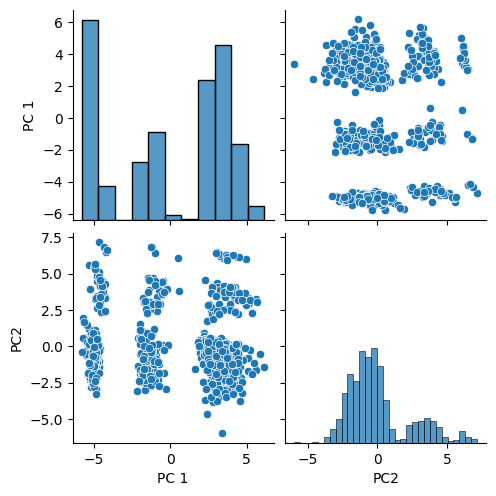

<Figure size 800x800 with 0 Axes>

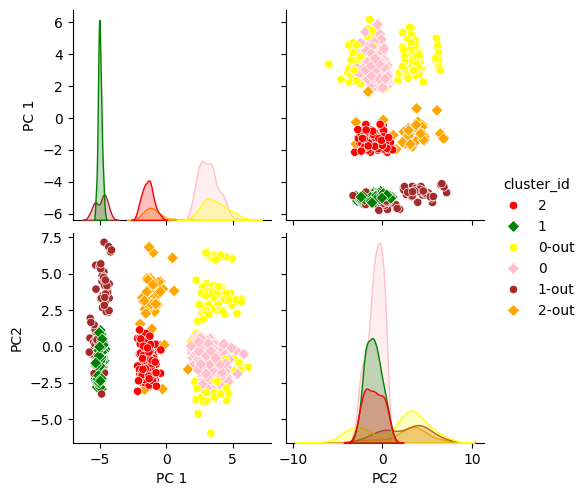

<Figure size 800x800 with 0 Axes>

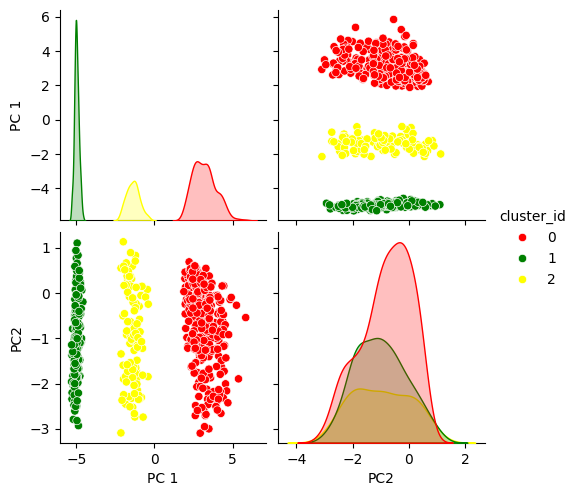

In [35]:
# OPTIMAL VISUALIZATION
from sklearn.decomposition import PCA
import seaborn as sns 

# PCA variable input
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)
df_pca = pd.DataFrame(df_pca, columns=['PC 1', 'PC2'])
plt.figure(figsize=(8,8))
sns.pairplot(data=df_pca)

# PAIR PLOT OPTIMAL with OUTLIERS
df_pca['cluster_id'] = best_cluster.loc[:, best_cluster.columns.isin(['cluster_id'])]

plt.figure(figsize=(8,8))
sns.pairplot(data=df_pca, hue='cluster_id', markers=["o", "D"], palette=['red', 'green', 'yellow', 'pink', 'brown', 'orange', 'blue'])

#PAIR PLOT OPTIMAL without OUTLIERS
df_pca['cluster_id'] = best_inliers.loc[:, best_inliers.columns.isin(['cluster_id'])]
df_pca.dropna(inplace=True)
df_pca['cluster_id'] = df_pca['cluster_id'].astype(int)

plt.figure(figsize=(8,8))
sns.pairplot(data=df_pca, hue='cluster_id', palette=['red', 'green', 'yellow', 'pink', 'brown', 'orange', 'blue'])